In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [47]:
tf.keras.backend.set_floatx("float64")

class DNModel(tf.keras.Model):
    def __init__(self):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(32, activation=tf.nn.tanh)
        self.dense_2 = tf.keras.layers.Dense(32, activation=tf.nn.tanh)
        self.out = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)

        return self.out(x)
    
    
@tf.function
def loss(model, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        with tf.GradientTape() as tape_2:
            tape_2.watch(x)

            psi = model(x)

        d_psi = tape_2.gradient(psi, x)
    d2_psi = tape.gradient(d_psi, x)
    
    E_L = -0.5*1/psi*d2_psi + 0.5*x**2
    E = tf.math.reduce_mean(E_L)
    
    psi_detach = tf.stop_gradient(psi)
    return E, 2*(tf.math.reduce_mean(psi/psi_detach*E_L) - tf.math.reduce_mean(psi/psi_detach)*E)


@tf.function
def grad(model, x):
    with tf.GradientTape() as tape:
        E, loss_value = loss(model, x)

    return E, tape.gradient(loss_value, model.trainable_variables)



def sample(model, N, n):
    total = 0
    x_old = tf.random.uniform((N,1), minval=-2, maxval=2, dtype=tf.dtypes.float64)
    psi_old = model(x_old).numpy()
    
    for i in range(n):
        x_new = x_old + 2*tf.random.uniform((N,1), minval=-1, maxval=1, dtype=tf.dtypes.float64)
        psi_new = model(x_new).numpy()
      
    
        U = np.random.uniform(0, 1, (N,1))
        mask = ((psi_new/psi_old)**2 > U) #vectorized acceptance criterion
        x_old = x_old.numpy()
        x_new = x_new.numpy()
        
        x_old[mask]   = x_new[mask]  #move walkers
        psi_old[mask] = psi_new[mask]  #move walkers
        x_old = tf.convert_to_tensor(x_old, dtype=tf.dtypes.float64)
        total += np.sum(mask)
    
    return x_old, total

In [56]:
tf.random.set_seed(42)
model = DNModel()
optimizer = tf.keras.optimizers.Adam(0.01)

N = 5000
num_epochs = 1000
energy = []

for epoch in range(num_epochs):
    x = sample(model, N, 10)[0]
    E, gradients = grad(model, x)
    energy.append(E)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if epoch%50 == 0: 
        print(f"epoch: {epoch}, Energy: {E}")

epoch: 0, Energy: 10.972954570484347
epoch: 50, Energy: 0.5468337436013258
epoch: 100, Energy: 0.5294755385322474
epoch: 150, Energy: 0.506406304570121
epoch: 200, Energy: 0.5049455172624668
epoch: 250, Energy: 0.5496619705696365
epoch: 300, Energy: 0.5156734704202055
epoch: 350, Energy: 0.5151829542696762
epoch: 400, Energy: 0.5045065418822277
epoch: 450, Energy: 0.5313551804800658
epoch: 500, Energy: 0.5003821297308647
epoch: 550, Energy: 0.49937941526335017
epoch: 600, Energy: 0.5040177844289657
epoch: 650, Energy: 0.5029211308293473
epoch: 700, Energy: 0.5005812192613721
epoch: 750, Energy: 0.5008135490267279
epoch: 800, Energy: 0.5023572096779558
epoch: 850, Energy: 0.50669355334098
epoch: 900, Energy: 0.5006650396732899
epoch: 950, Energy: 0.5003130395634838


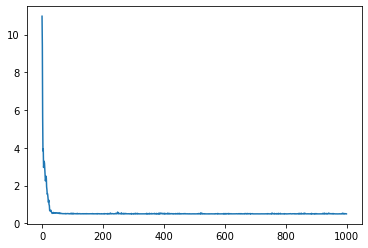

In [60]:
plt.plot(energy)
plt.show()

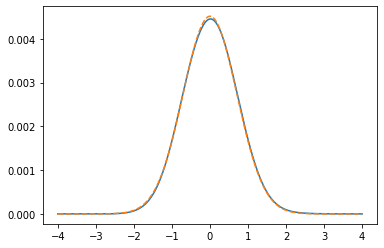

In [58]:
x_lin = np.linspace(-4, 4, 1000)
tf_x_lin = tf.convert_to_tensor(x_lin.reshape(-1,1), dtype=tf.dtypes.float64)

psi1 = model(tf_x_lin).numpy()[:, 0]
psi2 = np.exp(-0.5*x_lin**2)

plt.plot(x_lin, psi1**2/np.sum(psi1**2))
plt.plot(x_lin, psi2**2/np.sum(psi2**2), "--")
plt.show()